# Prerequisite: Install libraries
You'll need the `bitsandbytes` library installed for the quantization step in this notebook.

In [1]:
# One more package we need for this notebook
!pip3 install -U bitsandbytes

# this one is maybe needed depending what model you use
!pip3 install -U sentencepiece protobuf

# Zero-Shot Classification

We can group supervised learning into a few different "regimes" based on the amount of training data:
- Lots of training data: no special name for this.
    - E.g.: a few thousand pictures of cats and dogs, labeled for what animal they portray.
- Not a lot of data: few-shot learning.
    - E.g.: a few dozen pictures of cats and dogs, labeled for what animal they portray.
- Only one example: one-shot learning.
    - E.g.: here is _one_ picture of a cat, and _one_ picture of a dog.
- No training data: zero-shot learning.
    - E.g.: I don't have any pictures, but here's a description of a cat and a description of a dog.

Humans are great at one-shot and zero-shot learning.  Computers, historically have not been.  LLMs have done a lot to change that.

In this notebook, we'll focus on _zero-shot learning_ using large, generative models.

# Some major caveats and warnings

Generative models--while very cool, and shockingly good at doing one-shot and zero-shot learning, _should not be used blindly._  There are some _major_ concerns around their use.  A non-exhaustive list:

1. Data privacy.
    1. if you're using a model that isn't hosted locally, be sure you know their data privacy policies.  Uploading data to ChatGPT could be a violation of IRB protocols or data privacy laws.
    2. This is not an issue if you're hosting the the mode entirely locally.
3. Reproducibility.
    1. The same prompt won't always give the same results.  _This is the models working as they are supposed to.  It is impossible to fully prevent this behavior._  
    2. With local models you can set a fixed random seed for reproducibility.  _But reproducibility and correctness are not the same thing._
    3. Web-hosted models like ChatGPT might undergo significant changes with no notice.
4. Hallucinations.
    1. Generative models _are designed to hallucinate._  It is _mathematically impossible_ to prevent this without crippling the models.
    2. If accuracy is critical, _do not use these results without verifying them._  (At which point, you might not be saving yourself any work).
5. Output formats.
    1. Text-to-text models don't reliably produce machine-readable outputs.  You may have to do a lot of manual work or post-processing to convert text outputs into a machine-readable format, e.g. to do a statistical analysis on them.
6. Context windows.
    1. LLMs can only "remember" so much text.  This is less of an issue now than it used to be, but for very long texts, you may have to find a way to work around this limitation.
7. Instability.
    1. Small changes to your prompts might result in different outputs for each document.
    2. It is not possible to reason about how changes to the input will affect the output; these models are black boxes.
8. Cost.
    1. Generative LLMs aren't free.  They require _very_ high compute resources to run efficiently.  You're either buying GPUs, renting compute from somewhere like AWS, or paying a per-token price for API calls to something like ChatGPT.  This can get very expensive very quickly for some projects.
8. Factual accuracy.
   1. _LLMs do not have a notion of factual accuracy._  They only compute a _probable_ continuation of the text, _based on their training data_.  This can result in output that has the form of a factually true statement, _but the model is not aware of "factual accuracy" in either the inputs or outputs._
9. Meta-linguistic references and math.
    1. Generative models are consistently _awful_ at doing math, or at 

Generative models are not magic, they are not oracles, they are not universal problem solvers, they are not knowledge bases.  They are tools that generate text that looks like their training data.  Everything else they can do, while extremely impressive and very interesting, _is a happy accident._

_However,_ they still have some very compelling and interesting use cases.  We'll explore one of them here: zero-shot classification.

# Data

We'll use the same data as for document classification, but with a few tweaks.  Just to make our job easier, we'll focus only on 1-star and 5-star reviews, and ask the model to tell the difference between them.  (We could ask it to just guess the number of stars directly, but it's faster for us to check a binary prediction, and it still illustrates the point for this workshop).  But, we'll change a few column names around, so we can track the original label (the "ground truth") and the model's outputs side-by-side.

In [2]:
import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# use the smaller (10k reviews per star rating) test set--just for speed
data = datasets.load_dataset("yelp_review_full", split="test")

y = np.array(data["label"])
x = np.array(data["text"])

# only 1/5 star reviews.  Coded as 0-4 in the dataset.
keep = (y == 0) | (y == 4)
x = x[keep]
y = y[keep]

# convert to 0/1
y = (y / 4).astype(int)

data = pd.DataFrame({
    "Text": x,
    "Ground Truth": y,
})

# Pick and load a model

Next, we'll need to pick and load a model.  We'll pick a model designed for chat-type texts (a la ChatGPT).  These tend to generate output that works well for zero-shot classification.  These also tend to be _very_ large models--many billions of parameters--so we'll probably need to employ some tricks to get it to actually run on our hardware.

We'll use _quantization_, specifically.  This allows loading the model in _very_ low-precision numeric formats that should only have a minor impact on the final behavior.  If you're running this notebook somewhere with access to a big GPU--16gb of free VRAM or more--you can try out some of the other tricks that are commented out in the cell below.  You might get diffeent results, or at least faster runtimes.

The code below uses the Huggingface-trained model, Zephyr-7b-beta.  This model doesn't give the best results from my testing, but it doesn't require accepting any terms and conditions, or requesting access; anyone can use it with no extra steps.  If you want to use the other models here, you need to make a Huggingface account, go to to the Model Hub, find the model in question, and follow the steps to access the gated model.  (it's not hard, but it's more steps than I want to deal with for this workshop).  I would recommend the "instruct" models from the options in the cell below, but try them all out and do some compare-and-contrast.

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# recommended models--try both!
# model_name = "HuggingFaceH4/zephyr-7b-beta"
model_name = "HuggingFaceH4/mistral-7b-sft-beta"

# Mistral v0.3 tends to do better than HuggingFace's versions in my experience,
# but these are gated models.  You need a Huggingface account to access them,
# and need to accept their terms of use (basically just agreeing to the Apache
# 2.0 license terms, which are absurdly permissive).
# model_name = "mistralai/Mistral-7B-v0.3"
# model_name = "mistralai/Mistral-7B-Instruct-v0.3"

# Mixtral models are "mixture of experts" models.  Very good results, but also
# gated models, and the can be trickier to run.
# model_name = "mistralai/Mixtral-8x7B-v0.1"
# model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"

# Llama-3 is the current big hyped up model, but it is also gated and requires
# a bit more to access.
# model_name = "meta-llama/Meta-Llama-3-8B"
# model_name = "meta-llama/Meta-Llama-3-8B-instruct"

tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # trick 1: quantization.  Makes the model a lot smaller --> uses less VRAM and is easier to run.
    # This will also handle device offloading, so some of the model will be executed on the GPU,
    # some on the CPU.  This results in slowdowns as data is copied between devices.
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    ),
    # set this explicitly to silence a warning
    low_cpu_mem_usage=True,
    
    # trick 2: use flash attention to speed up the self-attention block.  Only works if you're
    # on an NVidia Ampere or newer card.  You'll need to install the `flash-attn` library with pip,
    # which can be a bit tricky to get working.
    # attn_implementation="flash_attention_2",

    # trick 3: use 16-bit floats, INSTEAD of quantization.
    # `torch.float16` is a basic 16-bit float. Halves the memory usage of the models,
    # but they still need a lot of memory to run.  Try this if you have an older GPU
    # with a lot of VRAM.
    # torch_dtype=torch.float16
)
# put the model in evaluation mode; this won't track gradients and should speed things
# up a bit compared to being in training mode.
model.eval()

# only use .to("cuda") if you can fit the whole model onto your GPU and are NOT using
# quantization.  (or, feel free to try using it WITH quantization, but expect some
# possible issues).
# model = model.to("cuda")

# optional code to compile the model
# import sys
# if sys.version_info.minor <= 12 or torch.__version__.split(".")[1] >= "4":
#     clf = torch.compile(clf)
# else:
#     print(
#         f"Cannot compile the model.  Need a Python version *prior to* 3.12 (you have: {sys.version}), or "
#         f"a PyTorch version 2.4.0 or later (you have: {torch.__version__}"
#     )

# if we don't specify the padding token ID, we'll get a bunch of warnings about it being
# set automatically when we run inference.  This isn't a problem for the results, it's 
# just a bunch of extraneous output we don't want to see if we can avoid it.
model.generation_config.pad_token_id = tok.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Prep work: prompts

Generative models--especially instruction-tuned ones, and chat-oriented ones--typically need a prompt or carrier phrase to do zero-shot classification.  You can roughly think of these as being a set of instructions to give to the model, _but the model does not interpret these any different from normal input text._  Remember: the models are just predicting what word is likely to come next.  It just so happens that for chat-oriented models, they tend to be trained on data where one user asks another to do something, and the other user does it.  But you _cannot_ guarantee that the model will always follow directions, because it has no real notion of "directions."  Just text that it needs to keep running autocomplete on.

In [4]:
# our "carrier phrase" which is written in the form of instructions for the model to carry out.
prompt = (
    "I will provide you with the text of a review.  Please classify the review "
    "as either positive or negative.  The text of the review is as follows: {}"
)

# A sample review--crafted to have an ambiguous sentiment--that we'll use for some demos.
review = (
    "This album, the latest release from the legendary drone metal band Earth, marks a radical "
    "departure from their normal style.  Gone are the giant walls of guitar feedback and slow, "
    "drawn-out meandering riffs.  In their place is something new: repetitive, but structured, "
    "riffs, with a bit more of an acoustic and even country twang.  Die-hard fans of the band's"
    " older work may not be pleased, but this new direction holds much promise, even if this "
    "first offering in the new style is a pretty rough around the edges."
)

# Now create the messages in a "chat template".  The template is different for each model,
# but the tokenizer can convert things for it.  We just need to set the data up first.
# Note: different models will have different roles available.  "user" and "assistant"
# are common.  Some models have a "system" role.  We could pass several messages, alternating
# between user and assistant, to generate a "backlog" of messages to further bias the model
# towards a particular kind of output, but we'll just provide the user message here.
messages = [
    {"role": "user", "content": prompt.format(review)} ,
]
# format the messages into the expected chat format
model_inputs = tok.apply_chat_template(
    messages,
    return_tensors="pt",
    return_dict=True,
)

# run the prepared texts through the model and get the outputs.
generated_ids = model.generate(
    # input data
    **{k:v.to("cuda") for k,v in model_inputs.items()},
    # stop asking for more tokens after 256 tokens
    max_new_tokens=256,
    # sample randomly from high-likelihood next tokens
    do_sample=True,
)

# the outputs are currently just a tensor of numeric IDs, each corresponding to a
# token in the model's vocabulary.
print("GENERATED_IDS:")
print(generated_ids)

# The tokenizer can decode these numeric IDs into human-readable strings.
print("\nDECODED TEXT:")
print(tok.batch_decode(generated_ids)[0])

GENERATED_IDS:
tensor([[  523, 28766,  1838, 28766, 28767,    13, 28737,   622,  3084,   368,
           395,   272,  2245,   302,   264,  4058, 28723, 28705,  5919,   875,
          1575,   272,  4058,   390,  2477,  5278,   442,  7087, 28723, 28705,
           415,  2245,   302,   272,  4058,   349,   390,  6104, 28747,   851,
          4708, 28725,   272,  7345,  5614,   477,   272, 26361,  1605,   538,
          7503,  4028,  8599, 28725, 14191,   264, 14358, 20622,   477,   652,
          4123,  3238, 28723, 28705,   420,   538,   460,   272, 12351,  8133,
           302, 10686, 12139,   304,  3944, 28725, 10421, 28733,   406,   528,
           391,  2131, 12950,  2547, 28723, 28705,   560,   652,  1633,   349,
          1545,   633, 28747, 21435,  2468, 28725,   562, 28429, 28725, 12950,
          2547, 28725,   395,   264,  2286,   680,   302,   396,  1183, 27621,
           304,  1019,  2939,  2323,   602, 28723, 28705,  2941, 28733,  8896,
          8504,   302,   272,  4028, 

# Post-processing the output

Notice how we have both our input and the model's response in a single string.  We need to do a little work to parse this out.  All models have some way to indicate when the "speaker" changes; Zephyr uses `<|system|>`, `<|user|>`, and `<|assistant|>` to mark the start of the system, user, and assistant texts, respectively, and uses `</s>` to mark the end of an entire dialog.  We can use this to parse out the different dialog "turns" and just show the model's response.

We'll also wrap the above logic up into a function to make life a bit easier later on.

In [5]:
import re
from textwrap import wrap

def annotate(carrier_phrase, text, model=model, tok=tok):
    """Run the text `text` through the model `model`, and capture just the model's output."""
    # format the carrier phrase with the `text` input and apply the chat template.
    messages = [
        {"role": "user", "content": carrier_phrase.format(text)}
    ]
    model_inputs = tok.apply_chat_template(
        messages,
        return_tensors="pt",
        return_dict=True,
    )
    # get the model's responses
    generated_ids = model.generate(
        **{k:v.to("cuda") for k,v in model_inputs.items()},
        max_new_tokens=256,
        do_sample=True,
    )
    output = tok.batch_decode(generated_ids)[0]
    
    # split the text into system, user, and assistant chunks.
    if model_name in ("HuggingFaceH4/zephyr-7b-beta", "HuggingFaceH4/mistral-7b-sft-beta"):
        # sanity check: sometimes the tokens we want don't appear.
        if "<|user|>" not in output or "<|assistant|>" not in output:
            return "", ""
        output = re.split(r"(<\|user\|>|</s>|<\|system\|>|<\|assistant\|>)", output)
        user = output.index("<|user|>")
        assistant = output.index("<|assistant|>")
    elif model_name in ("mistralai/Mistral-7B-v0.3", "mistralai/Mistral-7B-Instruct-v0.3", "mistralai/Mixtral-8x7B-v0.1"):
        if "[INST]" not in output or "[/INST]" not in output:
            return "", ""
        output = re.split(r"(\[INST\]|\[/INST\]|</s>)", output)
        user = output.index("[INST]")
        assistant = output.index("[/INST]")
    else:
        raise ValueError(
            f"Oops, you need to add logic for the outputs from {model_name}."
            "You'll need to add logic to identify the start/end tokens for user "
            "and assistant roles."
        )

    user_input = wrap(output[user + 1].strip(), subsequent_indent="\t")
    model_response = wrap(output[assistant + 1].strip(), subsequent_indent="\t")
    return "\n".join(user_input), "\n".join(model_response)

Let's run our sample review through this new logic a few times, and see how different the results are across a few different runs.

In [6]:
for i in range(10):
    _, label = annotate(prompt, review, model=model, tok=tok)
    print(f"Annotation number {i+1}")
    print(f"\tMODEL SAYS: {label.strip()}")
    print()

Annotation number 1
	MODEL SAYS: Negative.

Annotation number 2
	MODEL SAYS: Negative.

Annotation number 3
	MODEL SAYS: This review is positive.

Annotation number 4
	MODEL SAYS: Positive

Annotation number 5
	MODEL SAYS: Negative.

Annotation number 6
	MODEL SAYS: Negative.

Annotation number 7
	MODEL SAYS: This review is negative.

Annotation number 8
	MODEL SAYS: The review is positive.

Annotation number 9
	MODEL SAYS: The reviewer has classified the album as a "radical departure" from
	the traditional style of the band, using unconventional musical
	elements and styles that are structured and acoustic. While die-hard
	fans of earlier efforts may be displeased, the reviewer sees
	potential in the new direction. However, the album is only considered
	"rough around the edges" by the reviewer, indicating that it may not
	be fully successful. Therefore, this review is negative.

Annotation number 10
	MODEL SAYS: The review is positive, as the reviewer expresses excitement and
	anticip

# Prompt Engineering

The model's output is pretty verbose.  This might be fine if we're manually reading them and putting values into a spreadsheet, but it would be nice if we could get machine-readable output directly from the model.  We can try to bias the model's outputs by "engineering" the prompt to do what we want--hence, "prompt engineering."

Some notes about prompt engineering:
- A good starting point: just add extra instructions to the prompt to tell the model what you want it to do.  Despite the models not actually "following directions," this can work surprisingly well.
- This is a _very_ fiddly process.  There is no "best" prompt (and no real way to evaluate the quality of prompts), and most of the tweaking ends up being educated guesswork.  It'll also be different for each model.  You can build a good intiution for what to do with your prompts, but there's still a lot of guess-and-check.
- _You may not be able to make the model do what you want._  It isn't always possible to force its output into a desired form.
- You might end up making the outputs worse.  There's no way to know until you try.

We'll do the simple thing: we'll tell the model to just say 0 or 1, and not explain its reasoning.  We'll see how that goes.

In [7]:
prompt = (
    "I will provide you with the text of a review.  Please classify the review "
    "as either positive or negative.  If the review is positive, you should only "
    "respond with the word '1'.  If the review is negative, you should only "
    "respond with the word '0'.  The text of the review is as follows: {}"
)

for i in range(10):
    print(f"Annotation number {i+1} for the Earth review")
    _, label = annotate(prompt, review, model=model, tok=tok)
    print(f"\tMODEL SAYS: {label.strip()}")
    print()

Annotation number 1 for the Earth review
	MODEL SAYS: The review is negative as it says that fans of the band's old work may
	not be pleased, and the first offering in the new style is rough
	around the edges. Therefore, the response should be '0'.

Annotation number 2 for the Earth review
	MODEL SAYS: 1

Annotation number 3 for the Earth review
	MODEL SAYS: Positive.

Annotation number 4 for the Earth review
	MODEL SAYS: Please provide the full text of the review. Additionally, based on the
	information you have thus far, it is unclear which style the listener
	is more familiar with or which release might have been the listener's
	favorite - both of which can impact how the album is received. Can
	you please provide additional context or information about the
	listener's past experiences with Earth's music?

Annotation number 5 for the Earth review
	MODEL SAYS: The statement is negative towards the reviewed material. Therefore,
	only '0' should be responded.

Annotation number 6 for t

Well, that worked a bit better--not perfect, but better than it was before.  Now let's run this over our actual data and compare the model to the ground truths.

In [8]:
# now, on our actual review data
for _, row in data.iloc[:10].iterrows():
    text = row["Text"]
    ground_truth = row["Ground Truth"]
    _, label = annotate(prompt, text, model=model, tok=tok)
    print("-" * 20)
    print(f"TEXT: {text}")
    print(f"\nMODEL SAYS: {label}")
    print(f"\nGROUND TRUTH: {ground_truth}")
    print("-" * 20)

--------------------
TEXT: I got 'new' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \nI took the tire over to Flynn's and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he'd give me a new tire \"this time\". \nI will never go back to Flynn's b/c of the way this guy treated me and the simple fact that they gave me a used tire!

MODEL SAYS: This is a negative review.

GROUND TRUTH: 0
--------------------
--------------------
TEXT: Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both t

Great!  Now we can have the model run over all of our texts and label them, with no need to do any labeling ourselves.  _Crucial caveat:_ even though our prompt includes instructions to only reply with a number, 0/1/2, _we cannot guarantee that the model's outputs will always be what we requested._  So you may run into some issues if you blindly assume that the output will always be an integer.

_Crucial caveat:_ these models are _non-deterministic_.  The same inputs might yield different outputs.  We can see that by running the same text through the model a few different times.

In [11]:
import numpy as np
from tqdm.notebook import tqdm

# create the column for storing the "raw" response from the model.
# If it already exists--e.g. if you're re-running this call--then don't.
# This avoids overwriting pervious runs' outputs.
if "Zero-shot Label" not in data:
    data["Zero-shot Label"] = ""

# only the first 1000--otherwise this will take many, many hours to run.
# This will still take a while, though.
for i in tqdm(data.index[:1000]):
    # skip any texts already annotated--in case we re-run this code a few times
    if data.loc[i, "Zero-shot Label"] != "":
        continue
    _, label = annotate(prompt, data.loc[i, "Text"], model=model, tok=tok)
    data.loc[i, "Zero-shot Label"] = label

# try converting everything to an int and see if it causes any problems--
# this will result in some missing values in most cases!
def try_convert(maybe_int):
    try:
        return int(maybe_int.strip())
    except ValueError:
        return np.nan
data["Converted Zero-shot Label"] = data["Zero-shot Label"].map(try_convert)

  0%|          | 0/1000 [00:00<?, ?it/s]

Successfully converted 29/1000 outputs to numeric values
F1: 0.675776397515528
Ground Truth
1    17
0    12
Name: count, dtype: int64
Converted Zero-shot Label
1.0    18
0.0    11
Name: count, dtype: int64


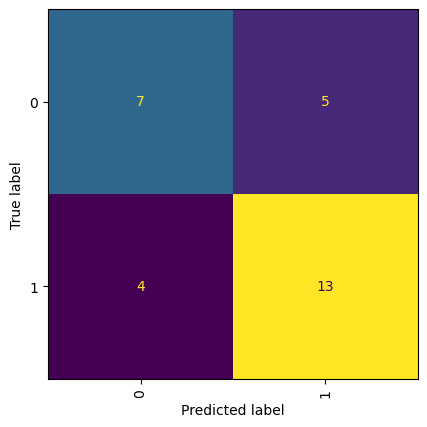

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

preds = data[data["Zero-shot Label"] != ""]

print(f"Successfully converted {data['Converted Zero-shot Label'].count()}/{preds.shape[0]} outputs to numeric values")

# check some error metrics
from sklearn.metrics import f1_score
preds = preds.dropna()
f1 = f1_score(preds["Ground Truth"], preds["Converted Zero-shot Label"], average="macro")
print(f"F1: {f1}")

print(preds["Ground Truth"].value_counts())
print(preds["Converted Zero-shot Label"].value_counts())
fix, ax = plt.subplots()
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=preds["Ground Truth"].astype(int),
    y_pred=preds["Converted Zero-shot Label"].astype(int),
    xticks_rotation="vertical",
    ax=ax,
    colorbar=False,
    # labels=["Negative", "Positive"],
)
plt.show()

# Some concluding notes

The above answers will be a bit worse than they could be for a few reasons:
- The models we used have 7 billion parameters.  This is on the small side for most generative models.  Larger models might give more consistent results, but be _extremely_ difficult to actually run.  And extremely slow.
- Quantization can effect text generation a bit more than other tasks.  Text generation is a lot more sensitive to initial conditions.  (this is likely not a _huge_ effect
- We didn't do a whole lot with prompt engineering.  E.g., we didn't provide a "system" message, which might have provided better results.
- We didn't tweak any of the generation options, like the `temperature` or `top_k` values (we left these at the defaults).
- Other models than Zephyr might give better results.  Mistral v0.3-instruct and Llama-3 might be good candidates to try.

We could do a few things with these results.  We could use them to jump-start a classifier model, or use them as suggestions for a human coder working through a lot of data (spot-checking can be easier than labelling from scratch!).